In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Data loading

In [2]:
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)

class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)


loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-2)

## Training

In [6]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, lr_scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        if lr_scheduler != None:
            lr_scheduler.step()
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    model.eval()
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
            prediction = model(x)
            
            indicies = torch.argmax(prediction, 1)
            res = indicies == y
            correct_samples += torch.sum(res)
            total_samples += y.shape[0]
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)


Average loss: 1.673692, Train accuracy: 0.468570, Val accuracy: 0.625828
Average loss: 1.139901, Train accuracy: 0.672098, Val accuracy: 0.695106
Average loss: 0.994915, Train accuracy: 0.710320, Val accuracy: 0.727186
Average loss: 0.919948, Train accuracy: 0.733150, Val accuracy: 0.733875
Average loss: 0.867863, Train accuracy: 0.748558, Val accuracy: 0.750665


In [7]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.165929, Train accuracy: 0.206446, Val accuracy: 0.248038
Average loss: 1.996532, Train accuracy: 0.275774, Val accuracy: 0.317180
Average loss: 1.810737, Train accuracy: 0.369860, Val accuracy: 0.404955
Average loss: 1.710148, Train accuracy: 0.416527, Val accuracy: 0.442700
Average loss: 1.680579, Train accuracy: 0.433079, Val accuracy: 0.441949


## Batch normalization

In [8]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 2.068587, Train accuracy: 0.319387, Val accuracy: 0.451300
Average loss: 1.762892, Train accuracy: 0.468143, Val accuracy: 0.522012
Average loss: 1.630481, Train accuracy: 0.533768, Val accuracy: 0.571156
Average loss: 1.545995, Train accuracy: 0.574429, Val accuracy: 0.617364
Average loss: 1.484100, Train accuracy: 0.606337, Val accuracy: 0.630674
Average loss: 1.434853, Train accuracy: 0.631830, Val accuracy: 0.621732
Average loss: 1.400582, Train accuracy: 0.650411, Val accuracy: 0.673128
Average loss: 1.378373, Train accuracy: 0.661622, Val accuracy: 0.688485
Average loss: 1.363204, Train accuracy: 0.673975, Val accuracy: 0.693741
Average loss: 1.352364, Train accuracy: 0.681278, Val accuracy: 0.708006


## Learning rate annealing

In [9]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10,
                                                       lr_scheduler=lr_scheduler)

Average loss: 2.068594, Train accuracy: 0.304013, Val accuracy: 0.430483
Average loss: 1.783966, Train accuracy: 0.463348, Val accuracy: 0.525425
Average loss: 1.662977, Train accuracy: 0.519930, Val accuracy: 0.555525
Average loss: 1.607753, Train accuracy: 0.546582, Val accuracy: 0.580916
Average loss: 1.569801, Train accuracy: 0.567792, Val accuracy: 0.596888
Average loss: 1.547027, Train accuracy: 0.579412, Val accuracy: 0.606716
Average loss: 1.530539, Train accuracy: 0.589769, Val accuracy: 0.611972
Average loss: 1.522150, Train accuracy: 0.594871, Val accuracy: 0.622210
Average loss: 1.513496, Train accuracy: 0.597260, Val accuracy: 0.623985
Average loss: 1.508216, Train accuracy: 0.601611, Val accuracy: 0.630059


### Wrong predictions visualising

In [10]:
class SubsetSampler(Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indicies):
    model.eval()
    predictions = np.array([])
    ground_truth = np.array([])
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=SubsetSampler(indicies))
    for i_step, (x, y) in enumerate(data_loader):
        prediction = model(x)
        predictions = np.append(predictions, torch.argmax(prediction, 1).numpy())
        ground_truth = np.append(ground_truth, y)
    
    return predictions, ground_truth

predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
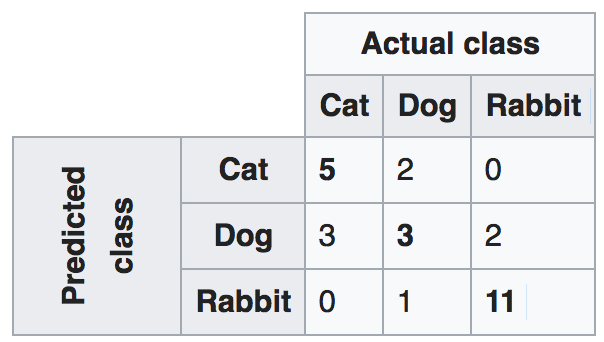

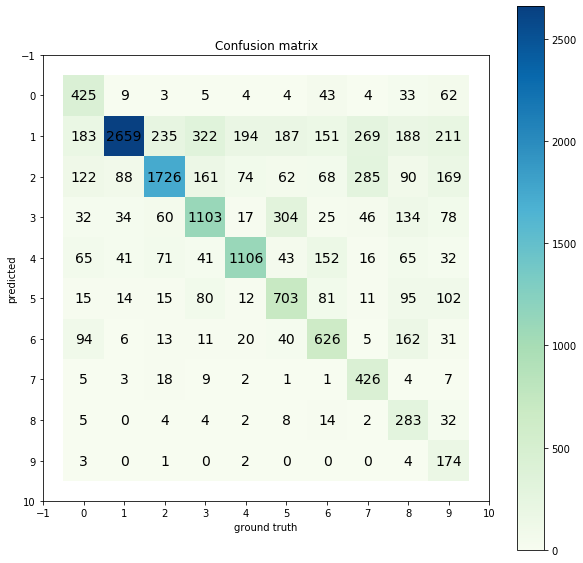

In [11]:
def visualize_confusion_matrix(confusion_matrix):
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(-1, size+1))
    plt.yticks(np.arange(-1, size+1))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth
    :param predictions: np array of ints, model predictions for all validation samples
    :param ground_truth: np array of ints, ground truth for all validation samples
    :return:
        np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    confusion_matrix = np.zeros((10,10), np.int)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            confusion_matrix[i, j] = np.sum((predictions == i) & (ground_truth == j))
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

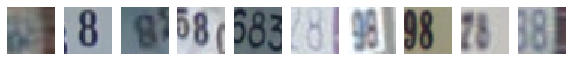

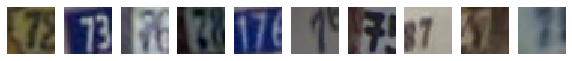

In [12]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
    :param indices: array of indices to visualize
    :param data: torch Dataset with the images
    :param title: string, title of the plot
    :param max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class
    :param predicted_class: int 0-9, index of the predicted class
    :param gt_class: int 0-9, index of the ground truth class
    :param predictions: np array of ints, model predictions for all validation samples
    :param groud_truth: np array of ints, ground truth for all validation samples
    :param val_indices: np array of ints, indices of validation samples
    :param data: torch Dataset
    """
    visualize_images(val_indices[(predictions == predicted_class) & (groud_truth == gt_class)], data)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Hyper-parameters 

In [13]:
first_hidden_layer = [100, 200]
second_hidden_layer = [100, 200]
learning_rate = [1e-3, 1e-4]
l2_reg = [1e-5, 1e-6]
num_epochs = 15
top_loss_history, top_train_history, top_val_history = None, None, None
top_val_accuracy = 0
top_model = None
top_optimizer = None

for fhl in first_hidden_layer:
    for shl in second_hidden_layer:
        for lr in learning_rate:
            for l2 in l2_reg:
                nn_model = nn.Sequential(
                            Flattener(),
                            nn.Linear(3*32*32, fhl),
                            nn.BatchNorm1d(fhl),
                            nn.ReLU(inplace=True),
                            nn.Linear(fhl, shl),
                            nn.BatchNorm1d(shl),
                            nn.ReLU(inplace=True),
                            nn.Linear(shl, 10), 
                         )
                optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=l2)
                print("lr: %f | fhl: %d | shl: %d | l2: %f" % (lr, fhl, shl, l2))
                loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs)
                if val_history[-1] > top_val_accuracy:
                    top_val_accuracy = val_history[-1]
                    top_val_history = val_history
                    top_train_history = train_history
                    top_loss_history = loss_history
                    top_model = nn_model
                    top_optimizer = optimizer

lr: 0.001000 | fhl: 100 | shl: 100 | l2: 0.000010
Average loss: 1.343095, Train accuracy: 0.565488, Val accuracy: 0.694970
Average loss: 0.927334, Train accuracy: 0.709023, Val accuracy: 0.756740
Average loss: 0.804993, Train accuracy: 0.748695, Val accuracy: 0.778377
Average loss: 0.739316, Train accuracy: 0.768966, Val accuracy: 0.791823
Average loss: 0.699266, Train accuracy: 0.781661, Val accuracy: 0.790663
Average loss: 0.663373, Train accuracy: 0.791557, Val accuracy: 0.812573
Average loss: 0.628793, Train accuracy: 0.803774, Val accuracy: 0.818169
Average loss: 0.612427, Train accuracy: 0.807255, Val accuracy: 0.817623
Average loss: 0.590539, Train accuracy: 0.814797, Val accuracy: 0.818101
Average loss: 0.577432, Train accuracy: 0.818397, Val accuracy: 0.819671
Average loss: 0.559650, Train accuracy: 0.824131, Val accuracy: 0.828339
Average loss: 0.543988, Train accuracy: 0.829181, Val accuracy: 0.832298
Average loss: 0.536600, Train accuracy: 0.829830, Val accuracy: 0.834209
A

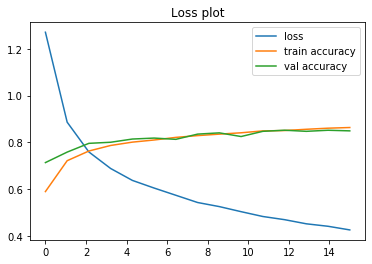

In [14]:
x = np.linspace(0, num_epochs, num_epochs)

plt.plot(x, top_loss_history, label='loss')
plt.plot(x, top_train_history, label='train accuracy')
plt.plot(x, top_val_history, label='val accuracy')

plt.title("Loss plot")

plt.legend()

plt.show()

In [15]:
num_epochs = 200

loss_history, train_history, val_history = train_model(top_model, train_loader, val_loader, loss, top_optimizer, num_epochs)

Average loss: 0.417859, Train accuracy: 0.867078, Val accuracy: 0.843765
Average loss: 0.405041, Train accuracy: 0.871122, Val accuracy: 0.848201
Average loss: 0.392053, Train accuracy: 0.875337, Val accuracy: 0.853662
Average loss: 0.381753, Train accuracy: 0.877982, Val accuracy: 0.849635
Average loss: 0.373005, Train accuracy: 0.880831, Val accuracy: 0.846973
Average loss: 0.360982, Train accuracy: 0.883800, Val accuracy: 0.849703
Average loss: 0.359534, Train accuracy: 0.884056, Val accuracy: 0.857006
Average loss: 0.344321, Train accuracy: 0.889653, Val accuracy: 0.852775
Average loss: 0.339946, Train accuracy: 0.891496, Val accuracy: 0.849908
Average loss: 0.332876, Train accuracy: 0.892946, Val accuracy: 0.851409
Average loss: 0.331719, Train accuracy: 0.891922, Val accuracy: 0.854959
Average loss: 0.323249, Train accuracy: 0.895233, Val accuracy: 0.848065
Average loss: 0.314989, Train accuracy: 0.896819, Val accuracy: 0.856733
Average loss: 0.301600, Train accuracy: 0.902348, V

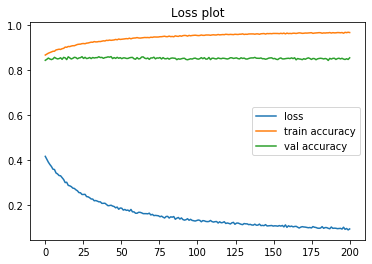

In [16]:
x = np.linspace(0, num_epochs, num_epochs)

plt.plot(x, loss_history, label='loss')
plt.plot(x, train_history, label='train accuracy')
plt.plot(x, val_history, label='val accuracy')

plt.title("Loss plot")

plt.legend()

plt.show()

In [17]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(top_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8180
